# Implementing Variational Mixture of Gaussians

Following Chapter 10 of Pattern Recognition and Machine Learning by Christopher M.
Bishop.

Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import time
from scipy.special import digamma, logsumexp, gamma
from scipy.stats import multivariate_normal, uniform
from tqdm import tqdm
from time import sleep
from sklearn.datasets import make_spd_matrix

%matplotlib inline
from IPython.display import clear_output

## Sampling Data

In [2]:
def gen_data(N, K, D):
    Nk = np.random.randint(0,N-1, K-1)
    Nk = list(np.sort(Nk))
    Nk.append(N)
    Nk.insert(0,0)
    for i in range(len(Nk) - 1,0, -1):
        Nk[i] = Nk[i] - Nk[i-1]
    Nk = np.array(Nk[1:])
    
    data = []
    medias = []
    covs = []
    for i in Nk:
        media = uniform.rvs(0, 15, D)
        cov = make_spd_matrix(D)
        data.append(multivariate_normal.rvs(mean = media, cov = cov, size = i))
        medias.append(media)
        covs.append(cov)
    
    print()
    print(Nk)
    print()
    print(np.array(medias))
    print()
    print(np.array(covs))

    data = np.concatenate((*data,))
    return data

## Functions

Implementing the functions stablished by the book:

\# 1:

$$ln(\tilde{\pi}_k) \equiv E[ln(\pi_k)] = \psi(\alpha_k)-\psi(\hat{\alpha})$$

In [3]:
def func1(aks):
    return digamma(aks) - digamma(np.sum(aks))

\# 2:

$$ln(\tilde{\Lambda}_k) \equiv E[ln(\Lambda_k)] = \sum^D_{i=1}\psi(\frac{\upsilon_k + 1 - i}{2}) + D\ln 2 + \ln |W_k|$$

In [4]:
def func2(v, D, Wk):
    temp1 = np.log([np.linalg.det(i) for i in Wk])
    temp2 = D*np.log(2)
    temp3 = np.sum(digamma(np.array([v+1-i for i in range(D)])/2), axis = 0)
    return temp1 + temp2 + temp3

\# 3:

$$ E_{\mu_k, \Lambda_k}[(x_n-\mu_k)^T\Lambda_k(x_n - \mu_k)] = D\beta^{-1}_k + \upsilon_k(x_n - m_k)^TW_k(x_n - m_k)$$

In [5]:
def func3(D, bk, vk, xn, mk, Wk):
    primera = D/bk
    temp = xn.reshape(xn.shape[0], 1, xn.shape[1]) - mk
    temp1 = np.einsum('jkl,ijk->ijl', Wk, temp, optimize = "optimal")
    segunda = np.einsum('j, ijk,ijk->ij', vk, temp, temp1,optimize = "optimal")
    return primera + segunda

\# 4:

$$ \ln \rho_{nk} =  E[ln(\pi_k)] + \frac{1}{2}E[ln(\Lambda_k)] - \frac{D}{2} \ln (2\pi) - \frac{1}{2} E_{\mu_k, \Lambda_k}[(x_n-\mu_k)^T\Lambda_k(x_n - \mu_k)]$$

In [6]:
def func4(Elnpi, Elnlam, D, Euklamk):
    temp = Elnpi + Elnlam/2 - D*np.log(2*math.pi)/2
    return temp.reshape((1, temp.shape[0])) - Euklamk/2

\# 5:

$$ r_{nk} = \frac{\rho_{nk}}{\sum^K_{j=1} \rho_{nj}} $$

In [7]:
def func5(lnpnk):
    temp = logsumexp(lnpnk, axis = 1)
    return np.exp(lnpnk - temp.reshape(temp.shape[0], 1))

\# 6

$$ N_{k} = \sum^N_{n=1} r_{nk} $$

We are not going to implement this function because of simplicity

\# 7:

$$ \bar{x}_{k} = \frac{1}{N_k}\sum^N_{n=1} r_{nk}x_n $$

In [8]:
def func7(N, r, x):
    return np.einsum('ij,ik,j->jk',r,x,1/N,optimize = "optimal")

\# 8:

$$ S_{k} = \frac{1}{N_k}\sum^N_{n=1} r_{nk}(x_n - \bar{x}_k)(x_n - \bar{x}_k)^T $$

In [9]:
def func8(Nk, r, x, xk):
    temp = x.reshape((x.shape[0], 1, x.shape[1])) - xk
    return np.einsum('ij,ijk,ijl,j->jkl', r, temp, temp, 1/Nk,optimize = "optimal")

\# 9

$$ \beta_{k} = \beta_0 + N_k $$

Not implemented because of simplicity

\# 10

$$ m_{k} = \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k) $$

In [10]:
def func10(bk, b0, m0, Nk, xbark):
    return np.einsum('ij,i->ij', b0*m0 + np.einsum('i,ij->ij', Nk, xbark), 1/bk,optimize = "optimal")

\# 11:

$$ W^{-1}_{k} = W^{-1}_0 + N_kS_k + \frac{\beta_0N_k}{\beta_0 + N_k}(\bar{x}_k - m_0)(\bar{x}_k - m_0)^T $$

In [11]:
def func11(W0inv, Nk, Sk, b0, barxk, m0):
    temp1 = (barxk - m0)
    temp1 = np.einsum('ik, il, i ->ikl', temp1, temp1, (b0*Nk)/(b0 + Nk),optimize = "optimal")
    temp2 = np.einsum('i, ijk -> ijk', Nk, Sk,optimize = "optimal")
    return W0inv + temp2 + temp1

\# 12


$$ \nu_k = \nu_0 + N_k$$

\# 13

$$ \alpha_k = \alpha_0 + N_k $$

\# 14

$$ E[\pi_k] = \frac{\alpha_k + N_k}{K\alpha_0 + N} $$

In [12]:
def func14(ak, Nk, a0, N):
    return (ak + Nk)/(len(ak)*a0 + N)

## Calculate Lower Bound

$$ E[\ln p(X|Z,\mu, \Lambda)] = \frac{1}{2}\sum^K_{k=1}N_k\{\ln \tilde{\Lambda}_k - D\beta^{-1}_k - \upsilon_kTR(S_kW_k) - \upsilon_k(\bar{x}_k-m_k)^TW_k(\bar{x}_k-m_k) - D\ln(2\pi)\} $$

In [13]:
def func15(Nk, lnlam, D, bk, vk, Sk, Wk, xbark, mk):
    temp = np.multiply(vk, np.trace(np.einsum("ijk,ijk->ijk", Sk, Wk), axis1 = 1, axis2 = 2))
    temp1 = np.einsum("i, ij, ijk, ij->i", vk, xbark - mk, Wk, xbark - mk)
    return np.dot(Nk, lnlam - D/bk - temp - temp1 - D*np.log(2*np.pi))/2

$$ E[\ln p(Z|\pi)] = \sum^N_{n=1}\sum^K_{k=1}r_{nk}\ln\tilde{\pi}_k $$

In [14]:
def func16(r, lnpik):
    return np.einsum("ij, j->", r, lnpik)

$$ C(\alpha) = \frac{\Gamma(\hat{\alpha})}{\Gamma(\alpha_1)\cdots\Gamma(\alpha_k)} $$

In [15]:
def func17(ak):
    temp = gamma(np.sum(ak))/np.prod(gamma(ak))
    if temp > 0:
        return temp
    else:
        return 1

$$ E[\ln p(\pi)] = \ln C(\alpha_0)+(\alpha_0-1)\sum^K_{k=1}\ln\tilde{\pi}_k $$

In [16]:
def func18(a0, lnpik):
    return np.log(func17(np.array([a0 for _ in range(len(lnpik))]))) + (a0 - 1)*np.sum(lnpik)

$$ B(W, \upsilon)  = |W|^{-\upsilon/2}(2^{\upsilon D/2}\pi^{D(D-1)/4}\prod^D_{i=1}\Gamma(\frac{\upsilon+1-i}{2}))$$

In [17]:
def func19(W0, v0, D):
    temp = np.linalg.det(W0)**(-v0/2)
    temp *= (2**(v0*D/2))*(np.pi**(D*(D-1)/4))
    temp *= np.prod(np.array([(v0+1-(i+1))/2 for i in range(D)]))
    return temp

$$ E[\ln p(\mu, \Lambda)] = \frac{1}{2}\sum^K_{k=1}\{D\ln (\beta_0/2\pi) + \ln\tilde{\Lambda}_k - \frac{D\beta_0}{\beta_k} - \beta_0\upsilon_k(m_k-m_0)^TW_k(m_k-m_0)\} + K \ln B(W_0, \upsilon_0) + \frac{(\upsilon_0 - D - 1)}{2} \sum^K_{k=1}\ln \tilde{\Lambda}_k - \frac{1}{2} \upsilon_k Tr(W_0^{-1}W_k)$$

In [18]:
def func20(D, b0, bk, lnlam, v0, vk, m0, mk, W0, Wk):
    temp = D*np.log(b0/(2*np.pi)) + lnlam - D*b0/bk
    temp1 = b0*np.einsum("i, ij, ijk, ij -> i", vk, mk-m0, Wk, mk-m0)
    primer = np.sum(temp + temp1)/2
    segunda = len(bk)*np.log(func19(W0, v0, D))
    temp = np.trace(np.einsum("jm, ijk->ijk", np.linalg.inv(W0), Wk), axis1 = 1, axis2 = 2)
    tercera = (v0 - D - 1)/2*np.sum(lnlam - np.multiply(vk, temp)/2)
    return primer + segunda + tercera

$$ E[\ln q(Z)] = \sum^N_{n=1}\sum^K_{k=1}r_{nk}\ln r_{nk} $$

In [19]:
def func21(r):
    temp = np.einsum("ij,ij->", r, np.log(r))
    if np.isnan(temp):
        return 1
    return temp

$$ E[\ln q(\pi)] = \sum^K_{k=1}(\alpha_k-1)\ln \tilde{\pi}_{k} + \ln C(\alpha) $$

In [20]:
def func22(ak, pik):
    return np.dot(ak-1, pik)+ np.log(func17(ak))

$$ H[\Lambda] = -\ln B(W,\upsilon) - \frac{(\upsilon-D-1)}{2}E[ln[\Lambda]]+\frac{\upsilon D}{2} $$

In [21]:
def func23(Wk, vk, D, lnlam):
    temp =  np.array([func19(Wk[i], vk[i], D) for i in range(len(Wk))])
    temp1 = (vk-D-1)/2*lnlam - vk*D/2
    return -temp-temp1

$$ E[\ln q(\mu, \Lambda)] = \sum^K_{k=1}\left\{\frac{1}{2}\ln \tilde{\Lambda}_k + \frac{D}{2}\ln \left(\frac{\beta_k}{2\pi}\right) - \frac{D}{2} - H[q(\Lambda_k)]\right\} $$

In [22]:
def func24(lnlam, D, bk, Wk, vk):
    return np.sum(lnlam/2 + (D/2)*np.log(bk/(2*np.pi))-D/2-func23(Wk, vk, D, lnlam))

$$ L = E[\ln p(X|Z,\mu,\Lambda)] + E[\ln p(Z|\pi)] + E[\ln p(\pi)] + E[\ln p(\mu,\Lambda)] -E[\ln q(Z)] - E[\ln q(\pi)]-E[\ln q(\mu,\Lambda)\ $$

In [23]:
def func25(pX, pZ, ppi, pmulam, qZ, qpi, qmulam):
    return pX + pZ + ppi + pmulam - qZ - qpi - qmulam

## Helpers

In [24]:
## From:
## https://github.com/jamesmcinerney/vbmm.git
## This function returns the "drawing" of an elipse for
## a mean and covariance of an specific normal distibution
from matplotlib.patches import Ellipse

def create_cov_ellipse(cov, pos, nstd=2, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    return ellip

# Main algorithm

In [25]:
def VGMM(data, K = 20, VERBOSE = True):
    # N: number of data
    # dim: dimension
    N, dim = data.shape
    #initial parameters
    alpha0 = 0.1
    beta0 = (1e-20)*1.
    v0 = dim + 1
    m0 = np.zeros(dim)
    W0 = np.identity(dim)
    r = np.array([np.random.dirichlet(np.ones(K)) for _ in range(N)])
    
    # Stablish the limits for 2D visualization
    # Only visualize 2D
    if VERBOSE:
        dif1 = (max(data[:,0]) - min(data[:,0])) * 0.1
        dif2 = (max(data[:,1]) - min(data[:,1])) * 0.1
        min1 = min(data[:,0]) - dif1
        min2 = min(data[:,1]) - dif2
        max1 = max(data[:,0]) + dif1
        max2 = max(data[:,1]) + dif2
        
        
    Nk = 0
    ## Start algorithm
    ite = 0
    while True:
        # Count number of iterations
        ite += 1
        # Obtain Nk for comparing
        Nanterior = Nk
        
        #Calculate Nk
        Nk = r.sum(axis = 0) ## 6
        
        # When a Gaussian have's less than 10 data
        # it is eliminated. The data goes into
        # another gaussian
        if len(np.where(Nk < 3)[0]):
            r = np.delete(r, np.where(Nk < 3)[0], 1)
            Nk = np.delete(Nk, np.where(Nk < 3)[0])
        # If the change is less than
        # 0.005, algorithm stops
        elif sum(np.absolute(Nk-Nanterior)) < 0.005:
            # When the algorithm finishes, it prints
            # the quantity of data per gaussian, means
            # and covariance
            print("finish")
            print("iterations:",ite)
            print("Gaussians:", len(Nk))
            print()
            print(Nk)
            print()
            print(mk)
            print()
            print(Sk)
            break
        
        ## M step
        xbark = func7(Nk, r, data) ## 7
        Sk = func8(Nk, r, data, xbark)## 8
        betak = beta0 + Nk ## 9
        mk = func10(betak, beta0, m0, Nk, xbark) ## 10
        Wk = np.linalg.inv(func11(W0, Nk, Sk, beta0, xbark, m0)) ## 11
        vk = v0 + Nk + 1 ## 12
        alphak = alpha0 + Nk ## 13
        
        ## E step
        Pi = func1(alphak)## 1
        lnlam = func2(vk, dim, Wk) ## 2
        Egrande = func3(dim, betak, vk, data, mk, Wk) ## 3
        lnpnk = func4(Pi, lnlam, dim, Egrande) ## 4
        r = func5(lnpnk) ## 5
        
        ## Calculate ELBO for gaussians with two or three dimensions
        if ite > 1 and (dim == 2 or dim == 3):
            ElnpX = func15(Nk, lnlam, dim, betak, vk, Sk, Wk, xbark, mk) ## 10.71
            ElnpZ = func16(r,Pi)
            Elnppi = func18(alpha0, Pi)
            Elnpmulam = func20(dim, beta0, betak, lnlam, v0, vk, m0, mk, W0, Wk)
            ElnqZ = func21(r)
            Elnqpi = func22(alphak, Pi)
            Elnqmulam = func24(lnlam, dim, betak, Wk, vk)
            L = func25(ElnpX, ElnpZ, Elnppi, Elnpmulam, ElnqZ, Elnqpi, Elnqmulam)
            print(L)
        
        # Visualization:
        # warning: has a lot of overhead if there is a lot of data
        if VERBOSE:
            fig, ax = plt.subplots(figsize = (10,9))

            ax.set_xlim(min1, max1)
            ax.set_ylim(min2, max2)
            
            clear_output(wait=True)
            plt.scatter(data[:,0],data[:,1])
            plt.scatter(mk[:,0],mk[:,1],color='r')
            
            for k in range(len(Nk)):
                elipse = create_cov_ellipse(Sk[k], mk[k,:],color='r',alpha=0.3)
                ax.add_artist(elipse)
            plt.show()

In [26]:
K = np.random.randint(1, 10)
N = np.random.randint(100, 20000)
D = np.random.randint(1, 15)
print("Cantidad de gaussianas", K)
print("N", N)
print("Dimensiones", D)
data = gen_data(N, K, 2)

Cantidad de gaussianas 4
N 9238
Dimensiones 10

[3119 1776 3285 1058]

[[11.9643877   5.51647801]
 [ 1.91548316 12.12659445]
 [10.64484599  8.1304502 ]
 [ 3.85769223  6.31868691]]

[[[ 2.79546884 -0.28675499]
  [-0.28675499  0.85838392]]

 [[ 2.61289819  0.28831818]
  [ 0.28831818  0.68565713]]

 [[ 1.86373088  0.83134373]
  [ 0.83134373  0.74876227]]

 [[ 2.56139594 -0.38971183]
  [-0.38971183  0.60268014]]]


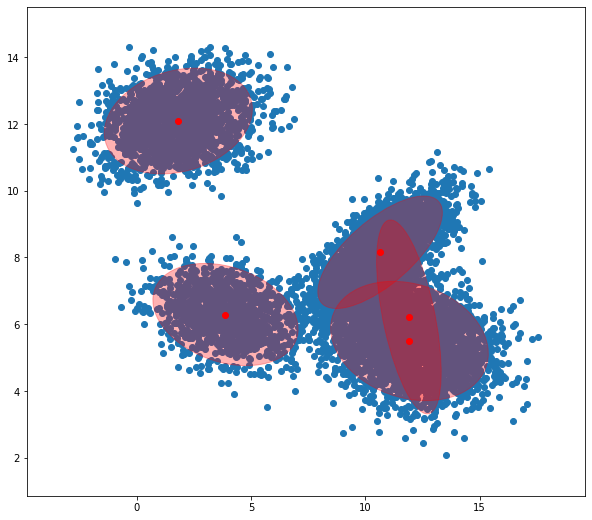

finish
iterations: 2681
Gaussians: 5

[1776.00590632  189.91288379 3202.08588909 3016.24738888 1053.74793191]

[[ 1.80844811 12.08674034]
 [11.89899369  6.21847358]
 [10.63936754  8.15438565]
 [11.92433549  5.49660814]
 [ 3.87227111  6.28895252]]

[[[ 2.62577581  0.28714824]
  [ 0.28714824  0.62761131]]

 [[ 0.49859674 -0.58368273]
  [-0.58368273  2.11030568]]

 [[ 1.85743876  0.80600371]
  [ 0.80600371  0.70987506]]

 [[ 2.97804314 -0.32456995]
  [-0.32456995  0.79876586]]

 [[ 2.52514442 -0.34636423]
  [-0.34636423  0.58617484]]]


In [27]:
VGMM(data, K=10, VERBOSE = True)

## Bibliography:
    - https://github.com/jamesmcinerney/vbmm.git